# **Fatima Fellowship Quick Coding Challenge**

**Deep Learning for Vision**

Upside down detector: Train a model to detect if images are upside down

 * Pick a dataset of natural images (we suggest looking at datasets on the Hugging Face Hub)
 * Synthetically turn some of images upside down. Create a training and test set.
 * Build a neural network (using Tensorflow, PyTorch, or any framework you like)
 * Train it to classify image orientation until a reasonable accuracy is reached
 * Upload the the model to the Hugging Face Hub, and add a link to your model below.
 * Look at some of the images that were classified incorrectly. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

**Submission instructions:** Please write your code below and include some examples of images that were classified

In [1]:
import os
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   161M      0  0:00:04  0:00:04 --:--:--  167M


In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls 

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [4]:
!ls PetImages

Cat  Dog


Deleted corrupted images and unnecessary files

In [5]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [6]:
os.chdir('/content/PetImages/Cat')

file = 'Thumbs.db'
    
location = "/content/PetImages/Cat"
    
path = os.path.join(location, file) 
    
os.remove(path) 

# Synthetically turned cat images upside down

In [7]:
from PIL import Image

os.chdir('/content/PetImages/Cat')

def rotateImages(rotationAmt):
  
  for image in os.listdir(os.getcwd()):
    
    img = Image.open(image)
    
    img.rotate(rotationAmt).save(image)
    
    img.close()
    

rotateImages(180)

print("Successfully Rotated")

Successfully Rotated


In [8]:
source = '/content/PetImages/Cat'
  

dest = '/content/PetImages/upside_down'
  
  
# using os.rename() method
os.rename(source, dest)
  
print("Successfully renamed.")

Successfully renamed.


# **Created a training and test set**

In [9]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


# Visualize the data

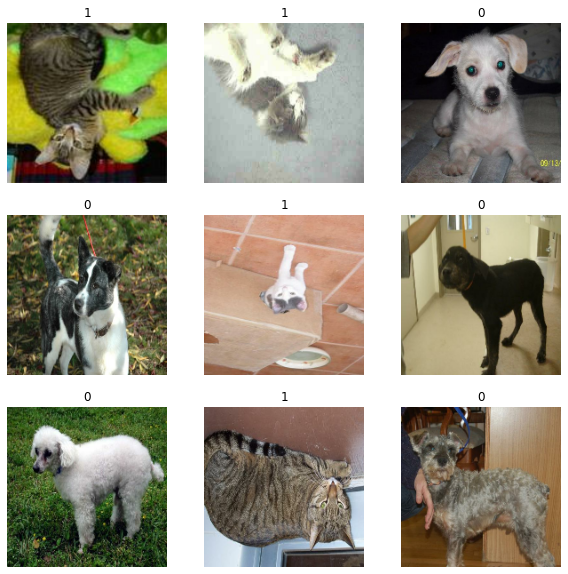

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Model

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
  

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x 

    for size in [128, 256, 512, 728, 1024]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 90, 90, 32)  128         ['conv2d[0][0]']             

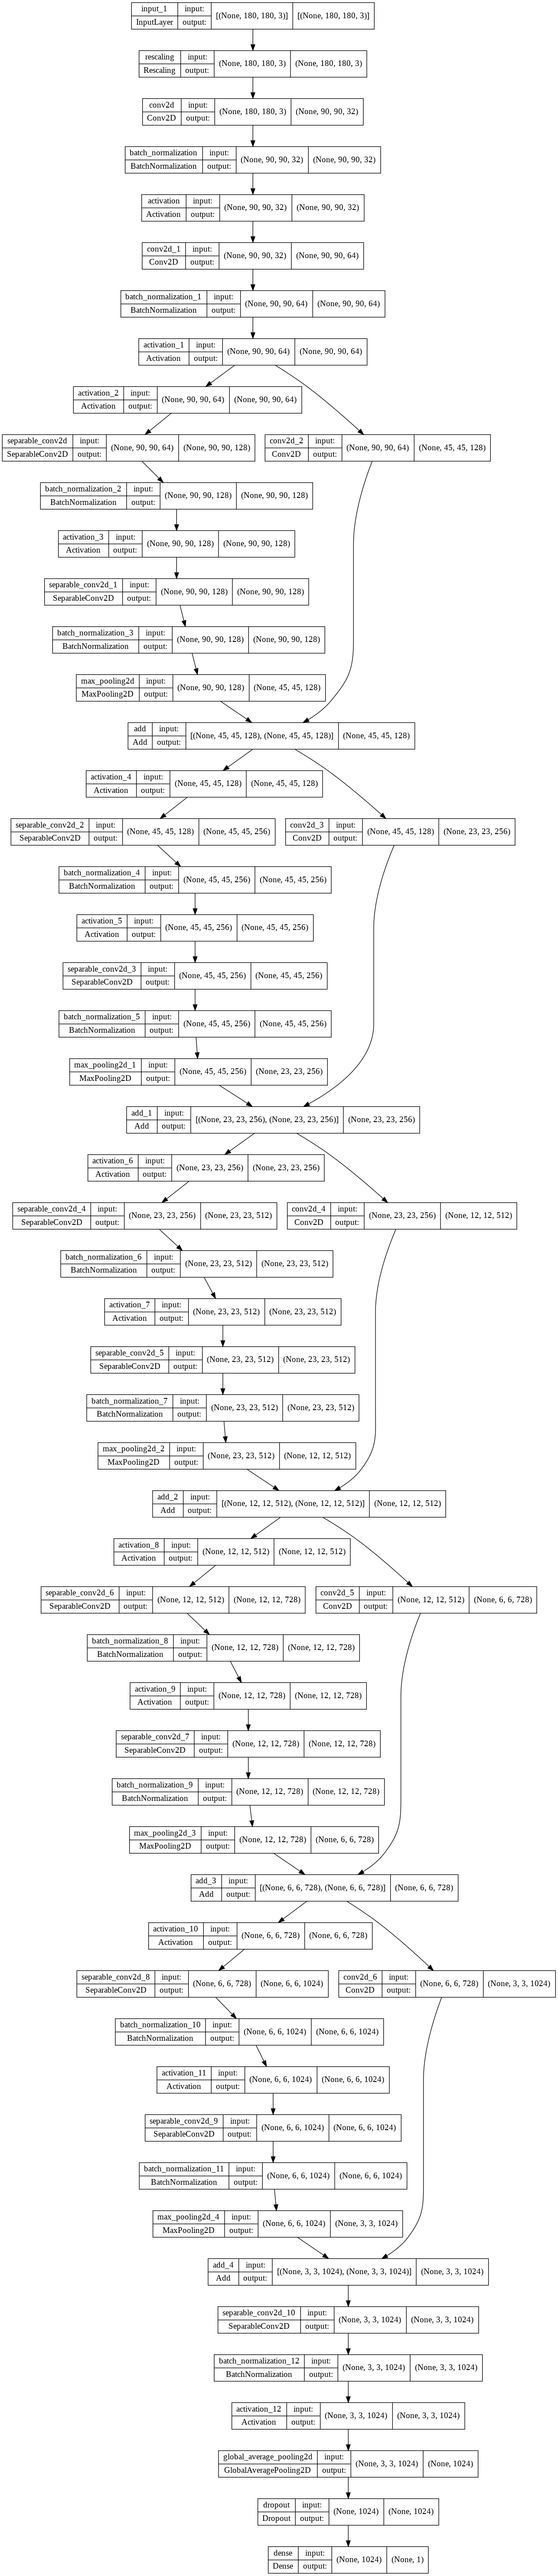

In [28]:
keras.utils.plot_model(model, show_shapes=True)

In [13]:
epochs = 50

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, validation_data=test_ds,
)

Epoch 1/50
586/586 [==============================] - 313s 507ms/step - loss: 0.4601 - accuracy: 0.7817 - val_loss: 0.3976 - val_accuracy: 0.8150
Epoch 2/50
586/586 [==============================] - 294s 502ms/step - loss: 0.2620 - accuracy: 0.8895 - val_loss: 0.3594 - val_accuracy: 0.8353
Epoch 3/50
586/586 [==============================] - 295s 502ms/step - loss: 0.1844 - accuracy: 0.9269 - val_loss: 0.3389 - val_accuracy: 0.8834
Epoch 4/50
586/586 [==============================] - 295s 502ms/step - loss: 0.1433 - accuracy: 0.9437 - val_loss: 0.1829 - val_accuracy: 0.9231
Epoch 5/50
586/586 [==============================] - 295s 502ms/step - loss: 0.1123 - accuracy: 0.9547 - val_loss: 0.2685 - val_accuracy: 0.9090
Epoch 6/50
586/586 [==============================] - 293s 498ms/step - loss: 0.0955 - accuracy: 0.9640 - val_loss: 0.1757 - val_accuracy: 0.9310
Epoch 7/50
586/586 [==============================] - 291s 496ms/step - loss: 0.0806 - accuracy: 0.9699 - val_loss: 0.2434 -

In [14]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


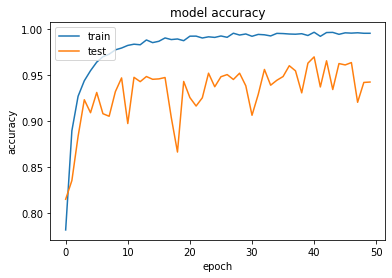

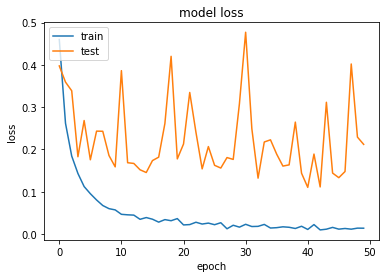

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
results = model.evaluate(test_ds, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.21211
Test Accuracy: 94.23%


In [18]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/PetImages/upside_down/10338.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent dog and %.2f percent upside_down."
    % (100 * (1 - score), 100 * score)
)

This image is 0.00 percent dog and 100.00 percent upside_down.


In [19]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/PetImages/upside_down/10888.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent dog and %.2f percent upside_down."
    % (100 * (1 - score), 100 * score)
)

This image is 0.00 percent dog and 100.00 percent upside_down.


In [21]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/PetImages/Dog/10208.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent dog and %.2f percent upside_down."
    % (100 * (1 - score), 100 * score)
)

This image is 99.91 percent dog and 0.09 percent upside_down.


In [23]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/PetImages/Dog/10117.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent dog and %.2f percent upside_down."
    % (100 * (1 - score), 100 * score)
)

This image is 99.88 percent dog and 0.12 percent upside_down.


In [24]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/PetImages/Dog/10044.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent dog and %.2f percent upside_down."
    % (100 * (1 - score), 100 * score)
)

This image is 52.72 percent dog and 47.28 percent upside_down.


In [25]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/PetImages/Dog/10135.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent dog and %.2f percent upside_down."
    % (100 * (1 - score), 100 * score)
)

This image is 99.99 percent dog and 0.01 percent upside_down.


In [26]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/PetImages/upside_down/10898.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent dog and %.2f percent upside_down."
    % (100 * (1 - score), 100 * score)
)

This image is 0.00 percent dog and 100.00 percent upside_down.


In [32]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/PetImages/upside_down/10945.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent dog and %.2f percent upside_down."
    % (100 * (1 - score), 100 * score)
)

This image is 0.00 percent dog and 100.00 percent upside_down.


In [33]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/PetImages/Dog/10008.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent dog and %.2f percent upside_down."
    % (100 * (1 - score), 100 * score)
)

This image is 100.00 percent dog and 0.00 percent upside_down.


# Incorrectly classified

In [34]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/PetImages/Dog/1859.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent dog and %.2f percent upside_down."
    % (100 * (1 - score), 100 * score)
)

This image is 2.85 percent dog and 97.15 percent upside_down.


In [42]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/PetImages/Dog/1745.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent dog and %.2f percent upside_down."
    % (100 * (1 - score), 100 * score)
)

This image is 49.18 percent dog and 50.82 percent upside_down.


# To improve performance will take some steps listed below: 
* Add more layers such as DepthwiseConv2D, Conv2DTranspose, pooling layers, normalization layers, etc.
* Need to change activation functions, loss functions, optimizers, and other HyperParameter.
